## A Minimal "MultiWormTracker"

I don't like MATLAB, so I wrote this.

Given an input `.avi` file, this notebook will output the position for each worm at each frame in a `.csv` file. Does not extract any other features or extrapolate between frames where a worm is lost. Edit the parameters in ALL CAPS to fit to your data.

### 1 Imports functions from the `mwt.py` script, which has to be in the same directory as this notebook

The script requires a couple non-standard packages which can be installed at once using `conda install joblib scikit-image ffmpeg`

In [1]:
from mwt import *

### 2 Locate files [EDIT]

The notebook requires a scratch directory with a lot of storage that will be filled with the `.avi` file converted into `.tif` for each individual frame. This scratch directory should have up to 75 GB free (51 GB used for a 1h 30' 3000x1500px recording) (36 GB used for a 45' 2500x2400px recording)

In [2]:
#EDIT, filenames with spaces don't quite work and so please replace with underscores first
INPUT_AVI = '/Volumes/DATA/092524_n2_0h-starve_dot.avi'
SCRATCH_PATH = '/Volumes/DATA'
OUTPUT_PATH = '/Users/albertwang/Desktop'
FRAME_LIMIT = None #if you'd like to process only N number of frames, otherwise keep as None to process the whole video

if not os.path.isfile(INPUT_AVI):
    raise FileNotFoundError()

### 3 Initialize scratch directory

In [3]:
scratch_dir = make_scratch_dir(INPUT_AVI, SCRATCH_PATH)
scratch_dir

'/Volumes/DATA/092524_n2_0h-starve_dot-scratch'

### 4 Makes a mask by getting one frame for each minute of the recording and getting the median of all those frames (3' for a 1h 30' 3000x1500px recording) (2' for a 45' 2500x2400px recording)

CPU times: user 11.9 ms, sys: 4.23 ms, total: 16.1 ms
Wall time: 40.1 ms


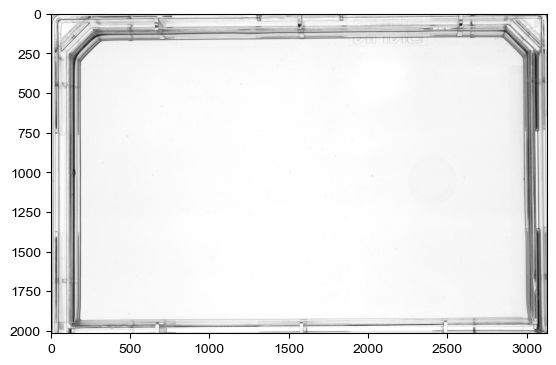

In [4]:
%%time

#make_mask(INPUT_AVI, scratch_dir, FRAME_LIMIT)
mask = get_and_show_mask(scratch_dir)

### 5 Try out worm detection parameters before running the pipeline [EDIT THE THRESHOLD PARAMETER] (STOP AFTER THIS CELL TO DOUBLE CHECK)

The threshold parameter varies for different videos depending on the overall brightness of the plate, pick even numbers around ten to make it so that the average area of the worm is around 100 px. This parameter will also be recorded in the output

This cell first detects blobs on a frame by subtracting each frame from the masking frame above and then thresholds that difference frame. A gaussian filter is also applied in between to smooth any blobs detected. It then chooses which blobs are worms by just picking ones that are roughly the size of a worm and also uses an eccentricity cutoff remove any features that may be from the edge of the plate.

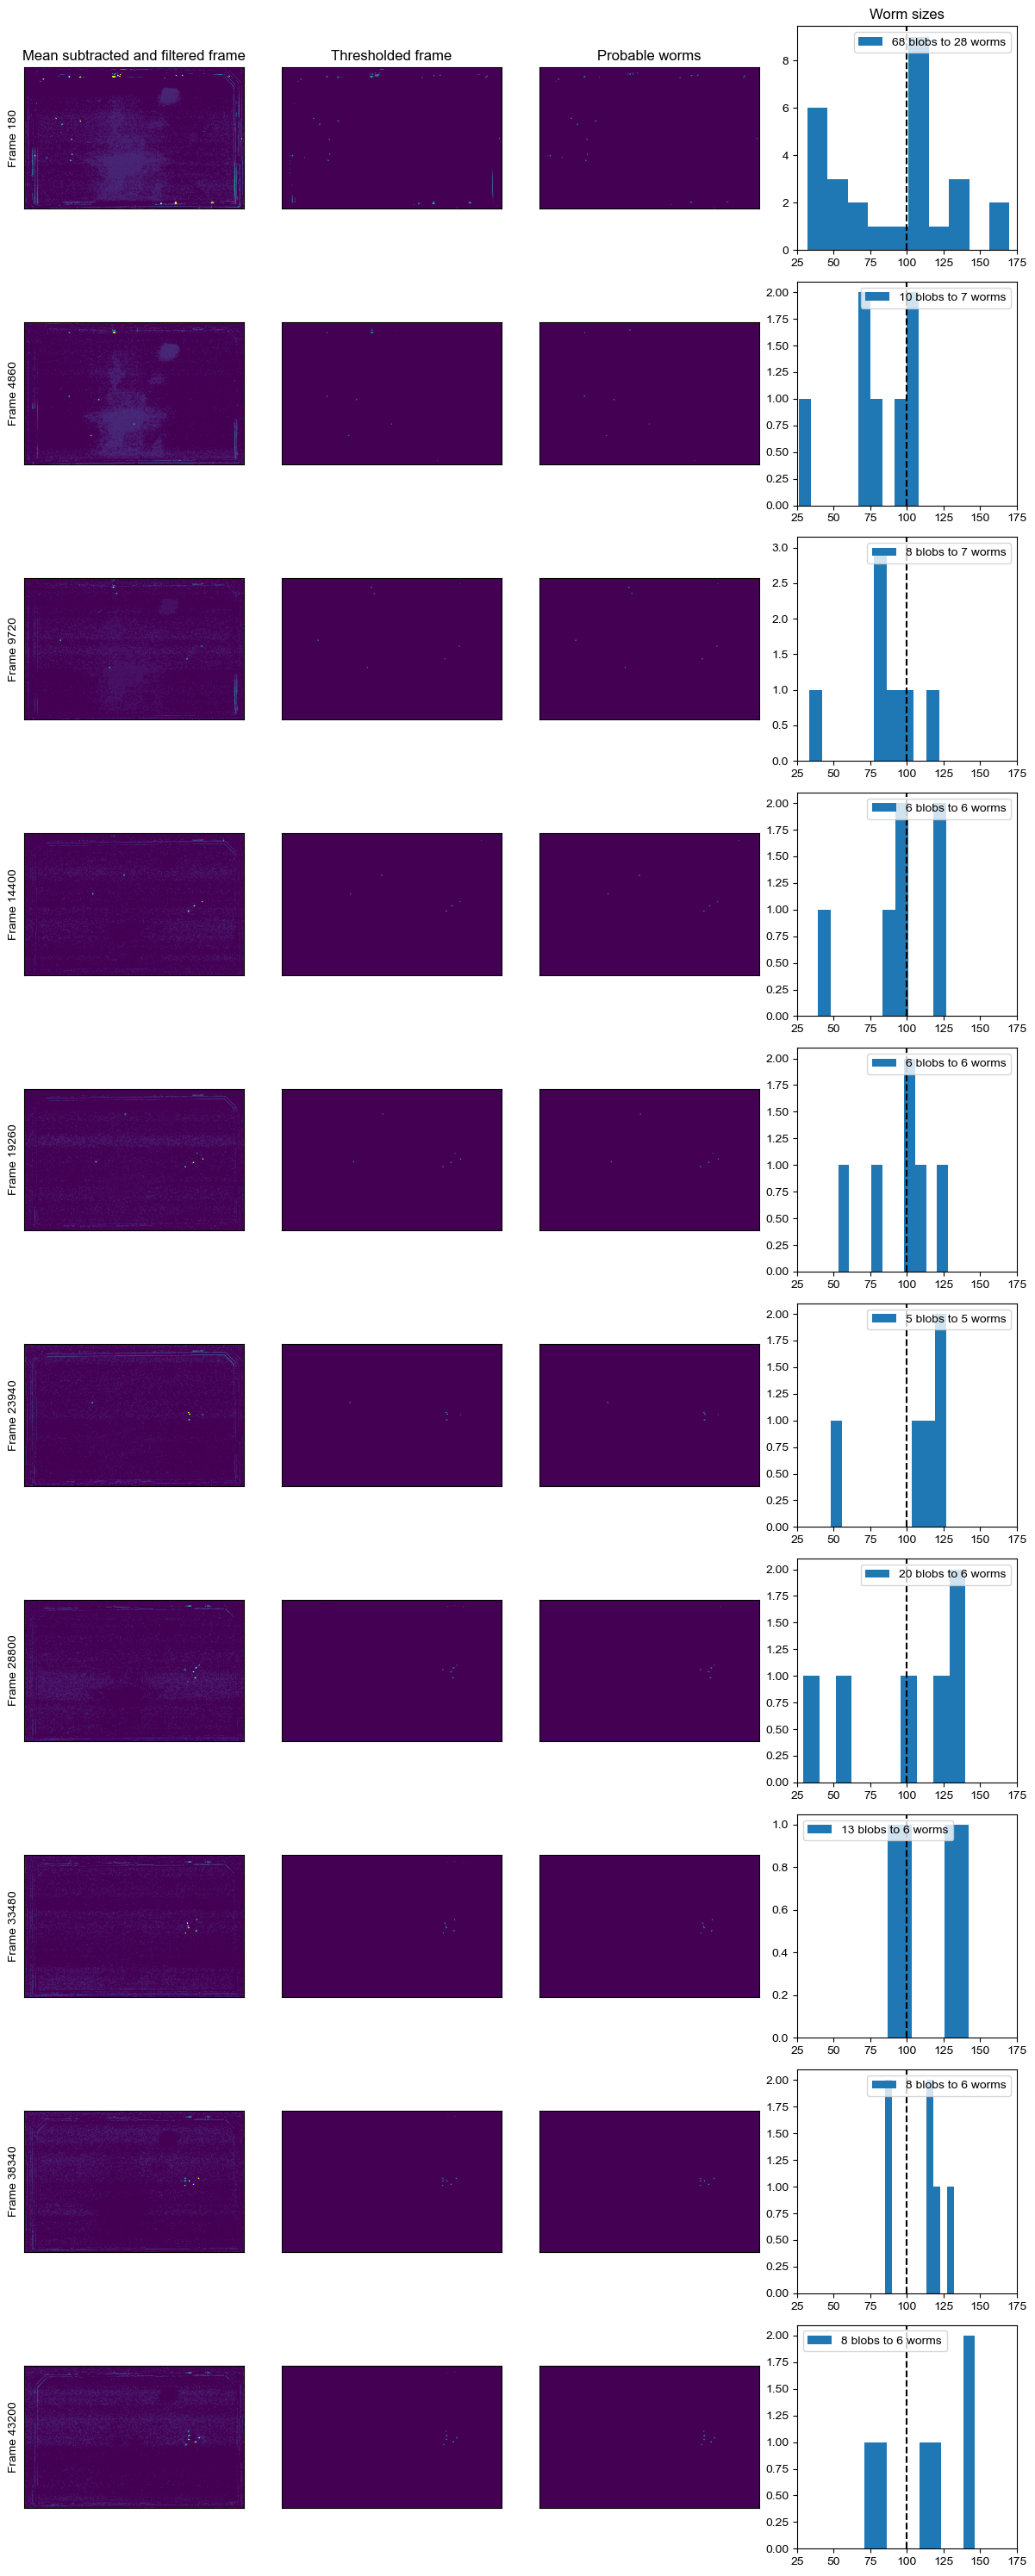

In [5]:
#EDIT
THRESHOLD = 10 #THE MOST IMPORTANT PARAMETER, adjust this so that the worm size is centered around 100
SIGMA = 2 #applies a gaussian filter with this sigma, can just be kept as two
AREA_RANGE = (25, 175) #chooses worms in this area range, can just be kept in this range
ECCENTRICITY_RANGE = (0, 0.99) #chooses worms in this eccentricity range, can just be kept in this range
IMAGE_MEAN = 240 #normalizes all plates to this average intensity, can just be kept as 240

check_params(scratch_dir, mask, THRESHOLD, SIGMA, AREA_RANGE, ECCENTRICITY_RANGE, IMAGE_MEAN, rows=10)

### 6 Convert `.avi` to `.tif` with `ffmpeg` (7' for a 1h 30' 3000x1500px recording) (5' for a 45' 2500x2400px recording)¶

In [6]:
%%time

#convert_to_tif(INPUT_AVI, scratch_dir, FRAME_LIMIT)
print('Frames converted: %i' % len(glob(os.path.join(scratch_dir, 'tif/*.tif'))))

Frames converted: 43199
CPU times: user 66.5 ms, sys: 13.1 ms, total: 79.6 ms
Wall time: 369 ms


### 7 Detect worms for each frame (10' for a 1h 30' recording w/ 10 worms) (7' for a 45' recording w/ 50 worms)

CPU times: user 13.9 s, sys: 2.83 s, total: 16.8 s
Wall time: 6min 19s


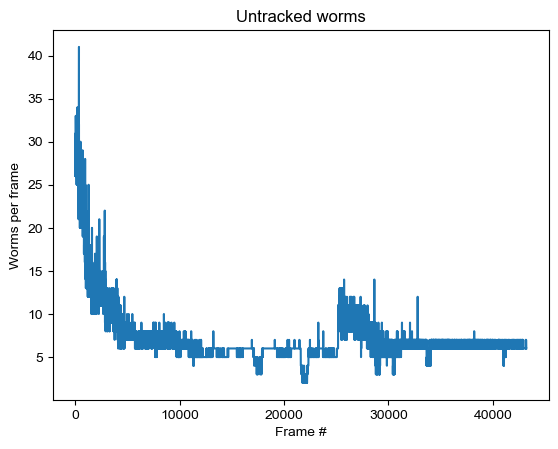

In [7]:
%%time

detect_worms(scratch_dir, mask, THRESHOLD, SIGMA, AREA_RANGE, ECCENTRICITY_RANGE, IMAGE_MEAN)
plot_worms(scratch_dir)

### 8 Link worms between each frame into a `.csv` (2' for a 1h 30' recording w/ 10 worms) (1' for a 45' recording w/ 50 worms)

CPU times: user 27.6 s, sys: 7.76 s, total: 35.3 s
Wall time: 4min 40s


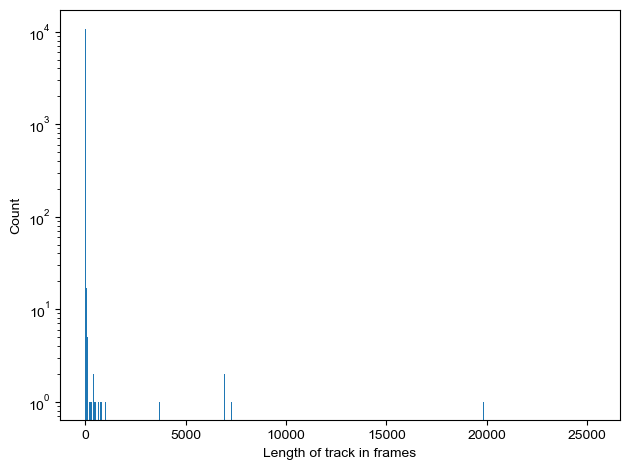

In [8]:
%%time

#CAN EDIT IF NEEDED (YOU PROBABLY DON'T)
SEPERATION = 10

link_worms(scratch_dir, SEPERATION)
plot_untrimmed(scratch_dir)

### 9 Trim out short tracks

Removes tracks that are too short and move too little

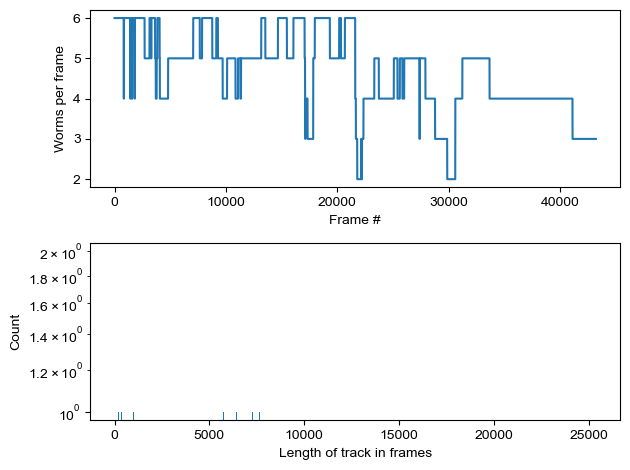

In [9]:
#CAN EDIT IF NEEDED (YOU ALSO PROBABLY DON'T)
MIN_FRAMES_SEEN = 90 #seen for more than 30 seconds
MIN_AREA_TRAVELED = 5000 #travels more than approximately a 3x3 mm square

trim_csv(scratch_dir, MIN_FRAMES_SEEN, MIN_AREA_TRAVELED)
plot_trimmed(scratch_dir)

### 10 One final visualization

CPU times: user 1.14 s, sys: 30.4 ms, total: 1.17 s
Wall time: 1.17 s


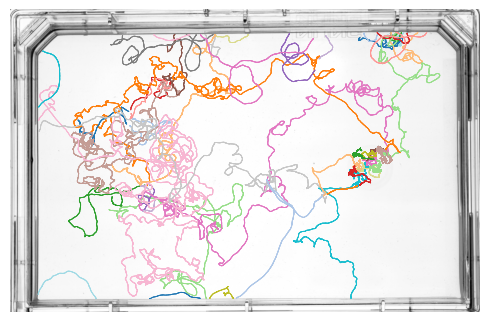

In [10]:
%%time

plot_tracks(scratch_dir, mask)

### 11 Copy all files to the output folder (must run this cell to save!)

In [11]:
%%time

save_params(scratch_dir, THRESHOLD, SIGMA, AREA_RANGE, ECCENTRICITY_RANGE, IMAGE_MEAN, SEPERATION, MIN_FRAMES_SEEN, MIN_AREA_TRAVELED)
copy_to_output(INPUT_AVI, OUTPUT_PATH, scratch_dir)

CPU times: user 859 μs, sys: 1.74 ms, total: 2.6 ms
Wall time: 57.1 ms


### 12 Delete the scratch directory on your own

In [12]:
#os.system('rm -rf %s' % scratch_dir)